In [1]:
from __future__ import print_function

In [2]:
import tensorflow as tf

In [3]:
from tensorflow.examples.tutorials.mnist import input_data

In [4]:
Z_NUM = 20
batch_size = 100

In [5]:
data = input_data.read_data_sets("../data_mnist/", one_hot=True)

Extracting ../data_mnist/train-images-idx3-ubyte.gz
Extracting ../data_mnist/train-labels-idx1-ubyte.gz
Extracting ../data_mnist/t10k-images-idx3-ubyte.gz
Extracting ../data_mnist/t10k-labels-idx1-ubyte.gz


In [6]:
input_dat = tf.placeholder(tf.float32, [batch_size, 784])
features = tf.reshape(input_dat,[batch_size, 28, 28, 1])

In [7]:
def recognition(features):
    fc1 = tf.nn.relu(tf.layers.conv2d(features, kernel_size=15, filters=16, name="RecogLayer1"))
    fc2 = tf.nn.relu(tf.layers.conv2d(fc1, kernel_size=8, filters=32,  name="RecogLayer2"))
    flat = tf.reshape(fc2,[batch_size, 7*7*32], name="RecogFlat")
    z_mu    = tf.nn.relu(tf.layers.dense(flat, Z_NUM, name="MeanLayer"))
    z_sigma = tf.nn.relu(tf.layers.dense(flat, Z_NUM, name="StddevLayer"))
    
    return z_mu, z_sigma

def generator(sample_z):
    gc1   = tf.nn.relu(tf.layers.dense(sample_z, 7*7*32, name="GenNet1"))
    z_img = tf.nn.relu(tf.reshape(gc1, [batch_size, 7, 7, 32]))
    gc2   = tf.nn.relu(tf.layers.conv2d_transpose(z_img, filters=16, kernel_size=8,name="GenNet2"))

    gc3   = tf.nn.sigmoid(tf.layers.conv2d_transpose(gc2, filters=1, kernel_size=15,  name="GenNet3"))
    return gc3

In [8]:
z_mu, z_sigma = recognition(features)

sample = tf.random_normal([batch_size,Z_NUM], 0, 1, dtype=tf.float32)
sample_z = z_mu + (z_sigma * sample)

gc3 = generator(sample_z)
g_flat = tf.reshape(gc3, [batch_size, 28*28], name="GenFlat")

In [9]:
gen_loss = -tf.reduce_sum(input_dat * tf.log(1e-8 + g_flat) + (1-input_dat) * tf.log(1e-8 + 1 - g_flat),1)
latent_loss = 0.5 * tf.reduce_sum(tf.square(z_mu) + tf.square(z_sigma) - tf.log(tf.square(z_sigma)) - 1,1)

cost = tf.reduce_mean(gen_loss + latent_loss)
optimizer = tf.train.AdamOptimizer(0.001).minimize(cost)

In [10]:
init = tf.global_variables_initializer()

sess = tf.InteractiveSession()
sess.run(init)
print('Training...')
for ep in range(10):
    for i in range(5000):
        batch_xs, batch_ys = data.train.next_batch(batch_size)
        optimizer.run({input_dat: batch_xs})

        if i % (batch_size*10) == 0:
            print('Epoch:%d, Steps Completed: %6d' % (ep,i))



Training...
Epoch:0, Steps Completed:      0
Epoch:0, Steps Completed:   1000
Epoch:0, Steps Completed:   2000
Epoch:0, Steps Completed:   3000
Epoch:0, Steps Completed:   4000
Epoch:1, Steps Completed:      0
Epoch:1, Steps Completed:   1000
Epoch:1, Steps Completed:   2000
Epoch:1, Steps Completed:   3000
Epoch:1, Steps Completed:   4000
Epoch:2, Steps Completed:      0
Epoch:2, Steps Completed:   1000
Epoch:2, Steps Completed:   2000
Epoch:2, Steps Completed:   3000
Epoch:2, Steps Completed:   4000
Epoch:3, Steps Completed:      0
Epoch:3, Steps Completed:   1000
Epoch:3, Steps Completed:   2000
Epoch:3, Steps Completed:   3000
Epoch:3, Steps Completed:   4000
Epoch:4, Steps Completed:      0
Epoch:4, Steps Completed:   1000
Epoch:4, Steps Completed:   2000
Epoch:4, Steps Completed:   3000
Epoch:4, Steps Completed:   4000
Epoch:5, Steps Completed:      0
Epoch:5, Steps Completed:   1000
Epoch:5, Steps Completed:   2000
Epoch:5, Steps Completed:   3000
Epoch:5, Steps Completed:   400

In [12]:
%matplotlib inline
import matplotlib.pyplot as plt
import numpy as np

In [12]:
# plt.figure(figsize=(8, 6)) 
# for _ in range(30):
#     x_sample, y_sample = data.test.next_batch(100)

#     z_m = sess.run(z_mu,{input_dat:x_sample})
#     plt.scatter(z_m[:, 0], z_m[:, 1], c=np.argmax(y_sample, 1))
# plt.colorbar()
# plt.grid()

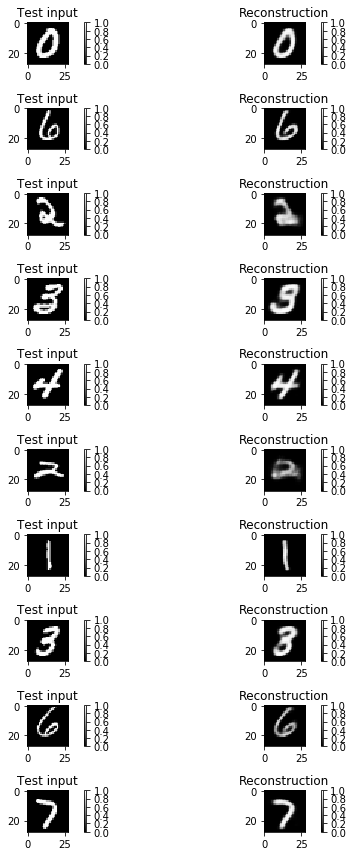

In [13]:
x_sample = data.test.next_batch(100)[0]
x_vae = sess.run(gc3, {input_dat:x_sample})
plt.figure(figsize=(8, 12))
for i in range(10):

    plt.subplot(10, 2, 2*i + 1)
    plt.imshow(x_sample[i].reshape(28, 28), vmin=0, vmax=1, cmap="gray")
    plt.title("Test input")
    plt.colorbar()
    plt.subplot(10, 2, 2*i + 2)
    plt.imshow(x_vae[i].reshape(28, 28), vmin=0, vmax=1, cmap="gray")
    plt.title("Reconstruction")
    plt.colorbar()
plt.tight_layout()

In [16]:
sample_dat = tf.placeholder(tf.float32, [batch_size, Z_NUM])
gc1   = tf.nn.relu(tf.layers.dense(sample_dat, 7*7*32, reuse=True, name="GenNet1"))
z_img = tf.nn.relu(tf.reshape(gc1, [batch_size, 7, 7, 32]))
gc2   = tf.nn.relu(tf.layers.conv2d_transpose(z_img, filters=16, kernel_size=8, reuse=True, name="GenNet2"))

gc3   = tf.nn.sigmoid(tf.layers.conv2d_transpose(gc2, filters=1, kernel_size=15, reuse=True, name="GenNet3"))


In [30]:
sample = np.random.rand(batch_size,Z_NUM)
out_img = sess.run(gc3, {sample_dat:sample})


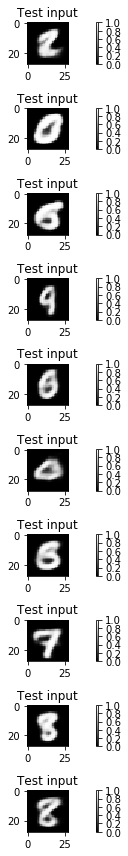

In [33]:
plt.figure(figsize=(8, 12))
for i in range(10):

    plt.subplot(10, 1, i+1)
    plt.imshow(out_img[i].reshape(28, 28), vmin=0, vmax=1, cmap="gray")
    plt.title("Test input")
    plt.colorbar()
plt.tight_layout()

In [68]:
weight_dict = {
    'Wr1': tf.Variable( tf.random_normal([784,300])),
    'br1': tf.Variable( tf.random_normal([300])),
    'Wr2_mean': tf.Variable( tf.random_normal([300,20])),
    'br2_mean': tf.Variable( tf.random_normal([20])),
    'Wr2_std': tf.Variable( tf.random_normal([300,20])),
    'br2_std': tf.Variable( tf.random_normal([20])),
    'Wg1': tf.Variable( tf.random_normal([20,300])),
    'bg1': tf.Variable( tf.random_normal([300])),
    'Wg2': tf.Variable( tf.random_normal([300,784])),
    'bg2': tf.Variable( tf.random_normal([784]))
}

In [70]:
out1 = tf.nn.relu(tf.matmul(input_dat, weight_dict['Wr1']) + weight_dict['br1'])
z_mean = tf.nn.relu(tf.matmul(     out1, weight_dict['Wr2_mean']) + weight_dict['br2_mean'])
z_std  = tf.nn.relu(tf.matmul(     out1, weight_dict['Wr2_std']) + weight_dict['br2_std'])

sample = tf.random_normal([batch_size,20], 0, 1, dtype=tf.float32)
sample_z = z_mean + (z_std * sample)

out2 = tf.nn.relu(tf.matmul(sample_z, weight_dict['Wg1']) + weight_dict['bg1'])
out_flat = tf.nn.sigmoid(tf.matmul(out2, weight_dict['Wg2']) + weight_dict['bg2'])

In [71]:
regularizer = tf.nn.l2_loss(weight_dict['Wr1']) + tf.nn.l2_loss(weight_dict['Wr2_mean']) + tf.nn.l2_loss(weight_dict['Wr2_std']) + tf.nn.l2_loss(weight_dict['Wg1']) + tf.nn.l2_loss(weight_dict['Wg2'])
gen_loss = -tf.reduce_sum(input_dat * tf.log(1e-8 + out_flat) + (1-input_dat) * tf.log(1e-8 + 1 - out_flat),1)
latent_loss = 0.5 * tf.reduce_sum(tf.square(z_mean) + tf.square(z_std) - tf.log(tf.square(z_std)) - 1,1)

cost = tf.reduce_mean(gen_loss + latent_loss + 0.005*regularizer)
optimizer = tf.train.AdamOptimizer(0.001).minimize(cost)

In [72]:
init = tf.global_variables_initializer()

sess = tf.InteractiveSession()
sess.run(init)
print('Training...')
for ep in range(20):
    for i in range(5000):
        batch_xs, batch_ys = data.train.next_batch(batch_size)
        optimizer.run({input_dat: batch_xs})

        if i % (batch_size*10) == 0:
            print('Epoch:%d, Steps Completed: %6d' % (ep,i))


Training...
Epoch:0, Steps Completed:      0
Epoch:0, Steps Completed:   1000
Epoch:0, Steps Completed:   2000
Epoch:0, Steps Completed:   3000
Epoch:0, Steps Completed:   4000
Epoch:1, Steps Completed:      0
Epoch:1, Steps Completed:   1000
Epoch:1, Steps Completed:   2000
Epoch:1, Steps Completed:   3000
Epoch:1, Steps Completed:   4000
Epoch:2, Steps Completed:      0
Epoch:2, Steps Completed:   1000
Epoch:2, Steps Completed:   2000
Epoch:2, Steps Completed:   3000
Epoch:2, Steps Completed:   4000
Epoch:3, Steps Completed:      0
Epoch:3, Steps Completed:   1000
Epoch:3, Steps Completed:   2000
Epoch:3, Steps Completed:   3000
Epoch:3, Steps Completed:   4000
Epoch:4, Steps Completed:      0
Epoch:4, Steps Completed:   1000
Epoch:4, Steps Completed:   2000
Epoch:4, Steps Completed:   3000
Epoch:4, Steps Completed:   4000
Epoch:5, Steps Completed:      0
Epoch:5, Steps Completed:   1000
Epoch:5, Steps Completed:   2000
Epoch:5, Steps Completed:   3000
Epoch:5, Steps Completed:   400

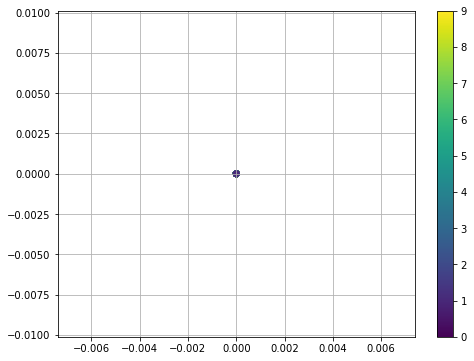

In [73]:
plt.figure(figsize=(8, 6)) 
for _ in range(30):
    x_sample, y_sample = data.test.next_batch(100)

    z_m = sess.run(z_mean,{input_dat:x_sample})
    plt.scatter(z_m[:, 0], z_m[:, 1], c=np.argmax(y_sample, 1))
plt.colorbar()
plt.grid()

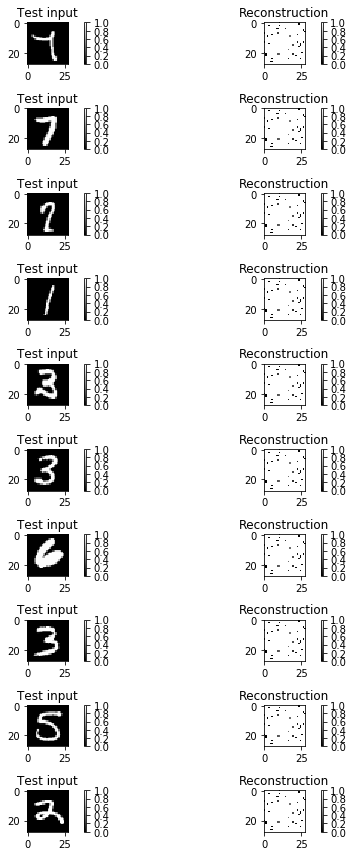

In [74]:
x_sample = data.test.next_batch(100)[0]
x_vae = sess.run(out_flat, {input_dat:x_sample})
plt.figure(figsize=(8, 12))
for i in range(10):

    plt.subplot(10, 2, 2*i + 1)
    plt.imshow(x_sample[i].reshape(28, 28), vmin=0, vmax=1, cmap="gray")
    plt.title("Test input")
    plt.colorbar()
    plt.subplot(10, 2, 2*i + 2)
    plt.imshow(x_vae[i].reshape(28, 28), vmin=0, vmax=1, cmap="gray")
    plt.title("Reconstruction")
    plt.colorbar()
plt.tight_layout()